In [32]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt


# Download latest version
path = kagglehub.dataset_download("rakannimer/air-passengers")

df = pd.read_csv(os.path.join(path, os.listdir(path)[0]), header=0, index_col=0, parse_dates=True)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [11]:
df.shape

(144, 1)

In [12]:
df.isna().any()

#Passengers    False
dtype: bool

In [13]:

print(df.dtypes)


#Passengers    int64
dtype: object


In [14]:
print(df.index)


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)


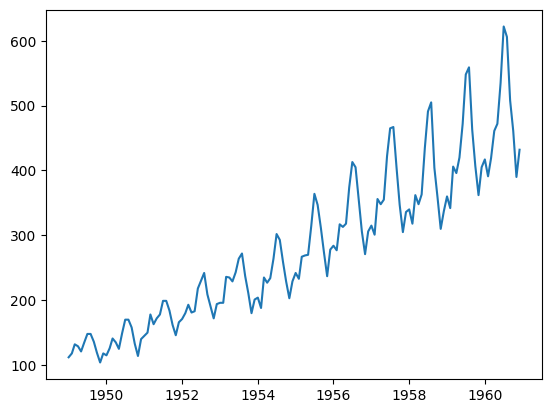

In [16]:
plt.plot(df)
plt.show()


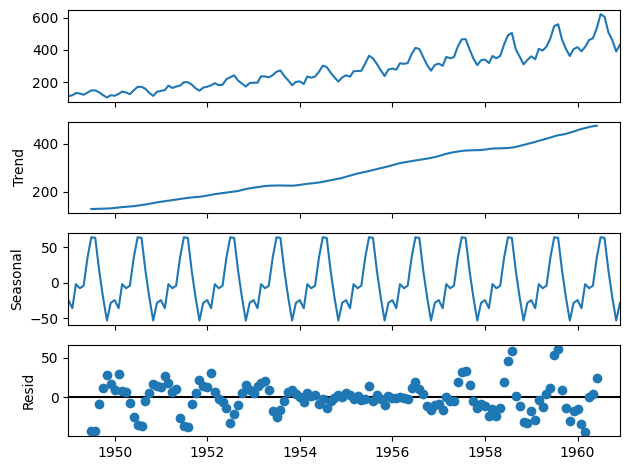

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df)
res.plot()
plt.show()

As we can see, the seasonal_decompose function allows us to obtain 3 graphs that identify the trend, seasonality, and residual.

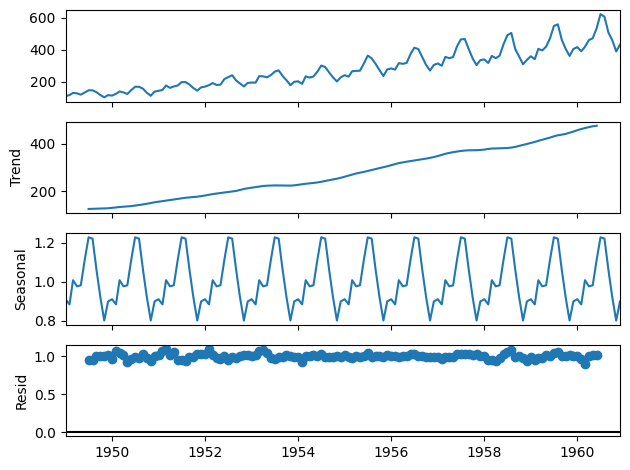

In [19]:
res = seasonal_decompose(df, model = 'multiplicative')
res.plot()
plt.show()

We indeed obtain a more satisfactory decomposition. We can identify a trend that increases linearly with time, as well as a seasonality with a period of 12 (annual). We could expect this seasonality frequency since we are dealing with monthly data.

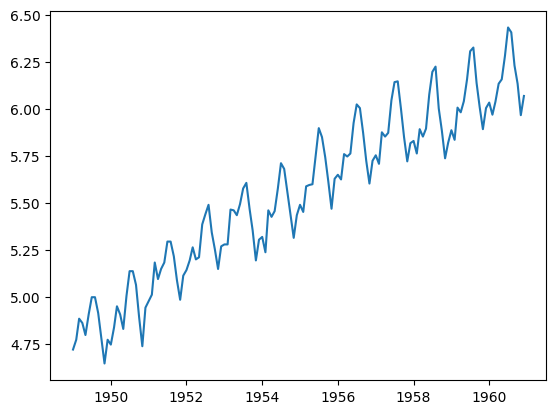

In [21]:
import numpy as np
airpasslog = np.log(df)
plt.plot(airpasslog)
plt.show()


By applying the logarithmic transformation, we observe a seasonality that seems to maintain a constant amplitude over time: we have switched to an additive model.

The seasonal attribute of the seasonal_decompose function allows access to the seasonality values.



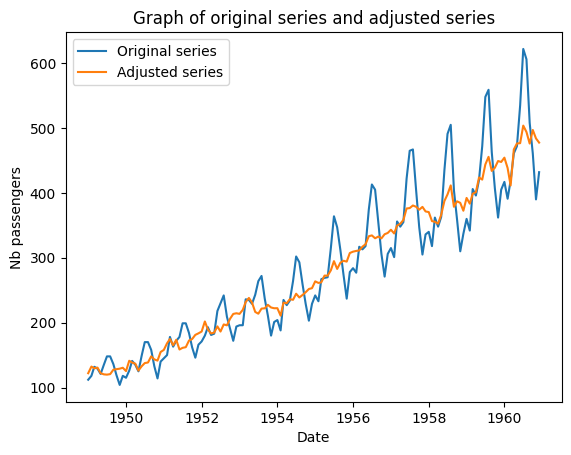

In [22]:
# Apply the seasonal_decompose function to airpasslog 
# Here we use the log transform to have an additive model

mult = seasonal_decompose(airpasslog)

# Subtract seasonal coefficients from the airpasslog series

cvs = airpasslog['#Passengers'] - mult.seasonal

# Apply exponential function to retrieve the original series

x_cvs = np.exp(cvs)

# Display the series

plt.plot(df, label='Original series')
plt.plot(x_cvs, label='Adjusted series') 

plt.title('Graph of original series and adjusted series')
plt.xlabel('Date')
plt.ylabel('Nb passengers')
plt.legend()
plt.show();

The question we can now ask: How does seasonal_decompose manage to identify trend, seasonality and residual from the series? Through the moving average method.

We will reproduce the method step by step to understand what the seasonal_decompose function does. Let's first see how to identify the trend using the moving average.

The rolling method from pandas allows selecting variables around one of them. Combined with the mean method, it allows obtaining the moving average. The center parameter of the rolling function is a boolean defining whether the calculation window should be centered on the current value.



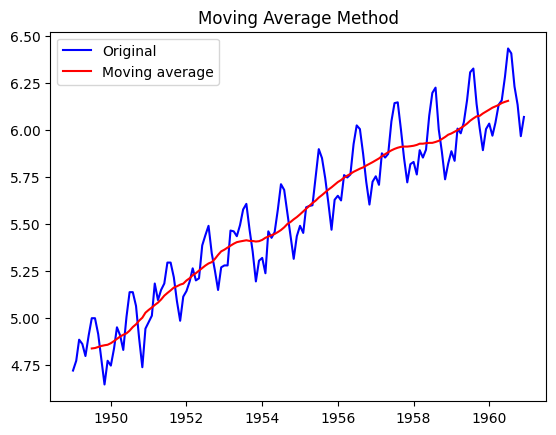

In [23]:
airpass_ma = airpasslog.rolling(window = 12, center = True).mean()

#Display the series

plt.plot(airpasslog, color = 'blue', label = 'Original')
plt.plot(airpass_ma, color = 'red', label = 'Moving average')
plt.legend()
plt.title('Moving Average Method')
plt.show()

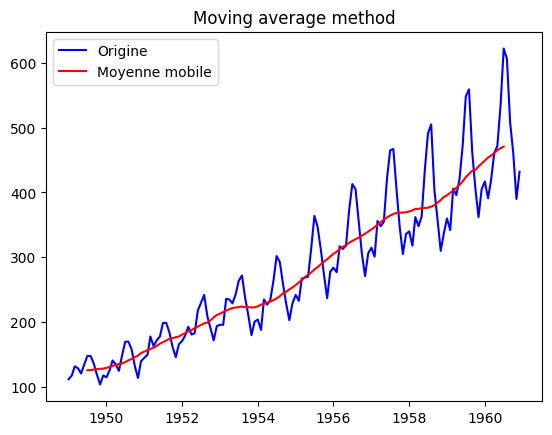

In [24]:
plt.plot(np.exp(airpasslog), color = 'blue', label = 'Origine')

plt.plot(np.exp(airpass_ma), color = 'red', label = 'Moyenne mobile')

plt.legend()

plt.title('Moving average method')

plt.show()



The moving average helps identify the trend which is linearly increasing in our case.

Seasonality as we said corresponds to a periodic phenomenon, so the idea is that we will identify coefficients for each seasonal variation. In our case, we have a seasonality with period 12, so we will determine 12 coefficients, one for each month of the year.

If we find these 12 coefficients, it will be easy for us to subtract the seasonality from the series. The writing of this model relies on the assumptions we made: linear trend and seasonality with period 12.

How do we determine these coefficients? Thanks to the moving average method.



In [27]:
airpasslog_without_ma = airpasslog - airpass_ma
airpasslog_without_ma.head(10)


,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,0.161034
1949-08-01,0.158831
1949-09-01,0.068807


In [28]:
airpasslog_without_ma = airpasslog_without_ma.dropna()
airpasslog_without_ma.head(10)


,#Passengers
Month,
1949-07-01,0.161034
1949-08-01,0.158831
1949-09-01,0.068807
1949-10-01,-0.070221
1949-11-01,-0.208742
1949-12-01,-0.085158
1950-01-01,-0.119133
1950-02-01,-0.039333
1950-03-01,0.061597


In [29]:
df=airpasslog_without_ma

df['month'] = (df.index).month

df.head(10)


,#Passengers,month
Month,,
1949-07-01,0.161034,7
1949-08-01,0.158831,8
1949-09-01,0.068807,9
1949-10-01,-0.070221,10
1949-11-01,-0.208742,11
1949-12-01,-0.085158,12
1950-01-01,-0.119133,1
1950-02-01,-0.039333,2
1950-03-01,0.061597,3


In [30]:
seasonality = df.groupby('month').mean()

seasonality = seasonality - seasonality.mean()


We now have the centered seasonal coefficient for each month. Last step before visualization: we will subtract the seasonal coefficients from the airpasslog series to obtain a seasonally adjusted series.

We notice that the airpass data goes from 01/01/1949 to 01/12/1960, which corresponds to 12 complete years. We can therefore create a vector of the same size as airpasslog, duplicate seasonality 12 times and subtract it from the original series.

In [31]:
seasonal_vector = np.zeros(144)

j=0
for i in range(12):
    seasonal_vector[j:j+12] = seasonality.iloc[:,0]
    j=j+12
    
    
# Subtract seasonal coefficients
airpasslog_cvs = airpasslog["#Passengers"] - seasonal_vector


# Retrieve the original series through exponential transformation
airpass_cvs = np.exp(airpasslog_cvs)

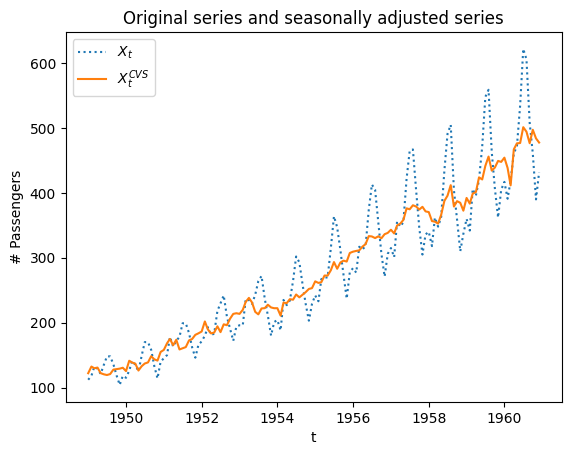

In [33]:
plt.plot(df, ':', label = '$X_t$')
plt.plot(airpass_cvs, label = '$X_t^{CVS}$')
plt.title('Original series and seasonally adjusted series')
plt.xlabel('t')
plt.ylabel('# Passengers')
plt.legend()

We can see on the  𝑋𝐶𝑉𝑆𝑡
  curve drops in attendance in 1958 and 1960 that would have been impossible to detect on the original curve. This is one of the benefits of deseasonalizing a time series.